# Performance of Bio-NICA on image sources

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nica_algorithms import bio_nica_direct, bio_nica_indirect, two_layer_nsm, nonnegative_pca
from util import permutation_error, add_fill_lines

### Load desired dataset

In [2]:
S = np.load('datasets/3-dim_images/sources.npy')
X = np.load('datasets/3-dim_images/mixtures.npy')

s_dim = S.shape[0]
x_dim = X.shape[0]
samples = S.shape[1]

In [3]:
# noncentered whitening for Nonnegative PCA

sig, U = np.linalg.eig(np.cov(X))
X_white = U@np.diag(1/(np.sqrt(sig+1e-10)))@U.T@X

### Sources

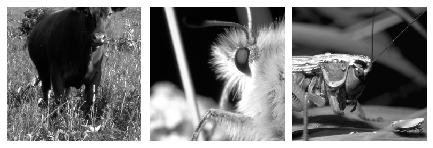

In [4]:
figure = plt.figure(figsize=(6,2))

for i in range(s_dim):
    plt.subplot(1,s_dim,i+1)
    plt.imshow(S[i].reshape(252,252), cmap="gray")
    plt.axis('off')

figure.tight_layout(pad=0.5)

plt.show()

### Mixtures

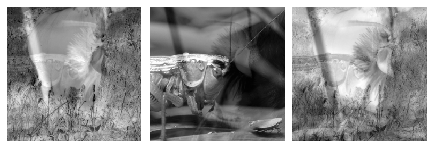

In [5]:
figure = plt.figure(figsize=(6,2))

for i in range(x_dim):
    plt.subplot(1,x_dim,i+1)
    plt.imshow(X[i].reshape(252,252), cmap="gray")
    plt.axis('off')

figure.tight_layout(pad=0.5)

plt.show()

### Bio-NICA

In [6]:
epochs = 15; iters = epochs*samples

In [7]:
trials = 10 # set the number of trials

bionica_direct_err = np.zeros((trials,iters))
bionica_indirect_err = np.zeros((trials,iters))
nsm_err = np.zeros((trials,iters))
npca_err = np.zeros((trials,iters))

In [8]:
for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
        
    # initialize algorithms

    n_dim = s_dim

    bionica_indirect = bio_nica_indirect(s_dim, x_dim, n_dim, 'images')
    bionica_direct = bio_nica_direct(s_dim, x_dim, 'images')
    nsm = two_layer_nsm(s_dim, x_dim, 'images')
    npca = nonnegative_pca(s_dim, x_dim, 'images')

    bionica_direct_Y = np.zeros((s_dim,iters))
    bionica_indirect_Y = np.zeros((s_dim,iters))
    nsm_Y = np.zeros((s_dim,iters))
    npca_Y = np.zeros((s_dim,iters))
    
    # data matrix for keeping track of permuted sources
    
    S_perm = np.zeros((s_dim,iters))
    
    # run online algorithms
    
    for i_epoch in range(epochs):
        
        print(f'Epoch {i_epoch+1} out of {epochs}:')

        idx = np.random.permutation(samples) # random permutation

        for i_sample in range(samples):
            
            i_iter = i_epoch*samples + i_sample

            S_perm[:,i_iter] = S[:,idx[i_sample]]
            
            x = X[:,idx[i_sample]]
            x_white = X_white[:,idx[i_sample]]

            bionica_indirect_Y[:,i_iter] = bionica_indirect.fit_next(x)
            bionica_direct_Y[:,i_iter] = bionica_direct.fit_next(x)
            nsm_Y[:,i_iter] = nsm.fit_next(x)
            npca_Y[:,i_iter] = npca.fit_next(x_white)

            # if a neuron hasn't fired by the 100th iteration, we flip the feedforward weights:

            if i_epoch==0 and i_sample==100:
                for j in range(s_dim):
                    if bionica_indirect_Y[j,0:i_sample].sum()==0:
                        bionica_indirect.flip_weights(j)
                    if bionica_direct_Y[j,0:i_sample].sum()==0:
                        bionica_direct.flip_weights(j)
                    if nsm_Y[j,0:i_sample].sum()==0:
                        nsm.flip_weights(j)
                    if npca_Y[j,0:i_sample].sum()==0:
                        npca.flip_weights(j)
                        
        print(f'Bio-NICA (Alg. 1) permutation error: {permutation_error(S[:,idx],bionica_indirect_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')
        print(f'Bio-NICA (Alg. 2) permutation error: {permutation_error(S[:,idx],bionica_direct_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')
        print(f'2-layer NSM permutation error: {permutation_error(S[:,idx],nsm_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')
        print(f'Nonnegative PCA permutation error: {permutation_error(S[:,idx],npca_Y[:,i_epoch*samples:(i_epoch+1)*samples])[-1]}')

    print('Computing errors...')

    bionica_indirect_err[i_trial,:] = permutation_error(S_perm,bionica_indirect_Y)
    bionica_direct_err[i_trial,:] = permutation_error(S_perm,bionica_direct_Y)
    nsm_err[i_trial,:] = permutation_error(S_perm,nsm_Y)
    npca_err[i_trial,:] = permutation_error(S_perm,npca_Y)

    print(f'Final Bio-NICA (Alg. 1) permutation error: {bionica_indirect_err[i_trial,-1]}')
    print(f'Final Bio-NICA (Alg. 2) permutation error: {bionica_direct_err[i_trial,-1]}')
    print(f'Final 2-layer NSM permutation error: {nsm_err[i_trial,-1]}')
    print(f'Final Nonnegative PCA permutation error: {npca_err[i_trial,-1]}')

Trial 1 out of 10:
Epoch 1 out of 15:
Bio-NICA (Alg. 1) permutation error: 1.692356723419485
Bio-NICA (Alg. 2) permutation error: 3.275655607584723
2-layer NSM permutation error: 0.04136895816041666
Nonnegative PCA permutation error: 0.04696560362721601
Epoch 2 out of 15:
Bio-NICA (Alg. 1) permutation error: 1.7326459508521959
Bio-NICA (Alg. 2) permutation error: 0.052000586167365005
2-layer NSM permutation error: 0.04011253001887687
Nonnegative PCA permutation error: 0.03161340822199893
Epoch 3 out of 15:
Bio-NICA (Alg. 1) permutation error: 1.746587194075016
Bio-NICA (Alg. 2) permutation error: 0.034660161575884016
2-layer NSM permutation error: 0.03970159455274496
Nonnegative PCA permutation error: 0.03173797899463833
Epoch 4 out of 15:
Bio-NICA (Alg. 1) permutation error: 1.7709657161033685
Bio-NICA (Alg. 2) permutation error: 0.030960214582407757
2-layer NSM permutation error: 0.0397543711773592
Nonnegative PCA permutation error: 0.031732222289765584
Epoch 5 out of 15:
Bio-NICA (A

Bio-NICA (Alg. 1):


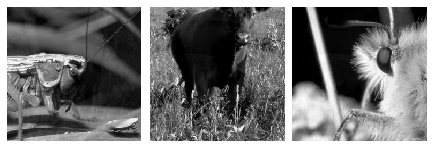

Bio-NICA (Alg. 2):


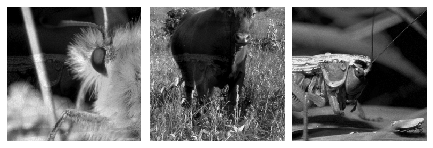

In [9]:
# Display recovered sources:

inv_idx = np.argsort(idx)

bionica_indirect_recovered = bionica_indirect_Y[:,-samples:]
bionica_direct_recovered = bionica_direct_Y[:,-samples:]

print('Bio-NICA (Alg. 1):')

figure = plt.figure(figsize=(6,2))

for i in range(s_dim):
    plt.subplot(1,s_dim,i+1)
    plt.imshow(bionica_indirect_recovered[i,inv_idx[:]].reshape(252,252), cmap="gray")
    plt.axis('off')

figure.tight_layout(pad=0.5)

plt.show()

print('Bio-NICA (Alg. 2):')

figure = plt.figure(figsize=(6,2))

for i in range(s_dim):
    plt.subplot(1,s_dim,i+1)
    plt.imshow(bionica_direct_recovered[i,inv_idx[:]].reshape(252,252), cmap="gray")
    plt.axis('off')
    
figure.tight_layout(pad=0.5)

plt.show()

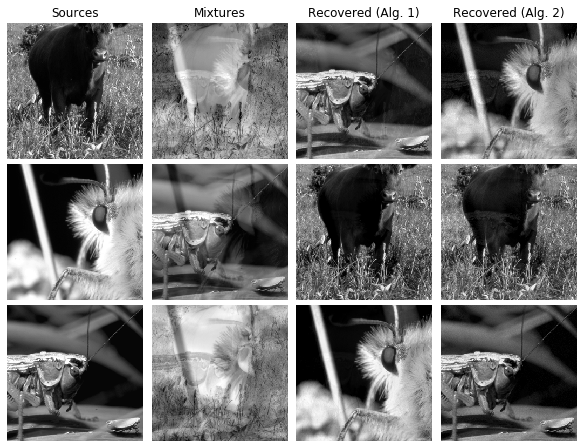

In [10]:
figure = plt.figure(figsize=(7.8,6))

plt.subplot(3, 4, 1)
plt.imshow(S[0].reshape(252,252), cmap="gray")
plt.axis('off')
plt.title('Sources')

plt.subplot(3, 4, 5)
plt.imshow(S[1].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(S[2].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(X[0].reshape(252,252), cmap="gray")
plt.axis('off')
plt.title('Mixtures')

plt.subplot(3, 4, 6)
plt.imshow(X[1].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(X[2].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(bionica_indirect_recovered[0,inv_idx[:]].reshape(252,252), cmap="gray")
plt.axis('off')
plt.title('Recovered (Alg. 1)')

plt.subplot(3, 4, 7)
plt.imshow(bionica_indirect_recovered[1,inv_idx[:]].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(bionica_indirect_recovered[2,inv_idx[:]].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(bionica_direct_recovered[0,inv_idx[:]].reshape(252,252), cmap="gray")
plt.axis('off')
plt.title('Recovered (Alg. 2)')

plt.subplot(3, 4, 8)
plt.imshow(bionica_direct_recovered[1,inv_idx[:]].reshape(252,252), cmap="gray")
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(bionica_direct_recovered[2,inv_idx[:]].reshape(252,252), cmap="gray")
plt.axis('off')

figure.tight_layout(pad=-.8)

plt.savefig('plots/image-transformations.png', dpi=300, transparent='true', bbox_inches='tight')
# plt.show()

### Comparison plots

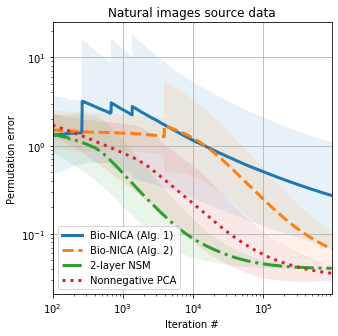

In [11]:
linewidth = 3

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, bionica_indirect_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA (Alg. 1)'})
add_fill_lines(ax, t, bionica_direct_err, plot_kwargs={'ls': '--', 'lw': linewidth, 'label': 'Bio-NICA (Alg. 2)'})
add_fill_lines(ax, t, nsm_err, plot_kwargs={'ls': '-.', 'lw': linewidth, 'label': '2-layer NSM'})
add_fill_lines(ax, t, npca_err, plot_kwargs={'ls': ':', 'lw': linewidth, 'label': 'Nonnegative PCA'})

ax.loglog()

plt.title(f"Natural images source data")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Iteration #')
plt.ylabel('Permutation error')
plt.xlim((1e2,iters))
# plt.ylim(bottom=10**-4,)
# plt.ylim(10**-3,10**.8)

plt.savefig(f'plots/images.png', dpi=300, transparent='true', bbox_inches='tight')
# plt.show()